**PRÁCTICA 2. RESOLUCIÓN DE PROBLEMAS DE OPTIMIZACIÓN MEDIANTE TENSORFLOW: ENTRENANDO UN PERCEPTRÓN SIMPLE**

**Conceptos necesarios de teoría**:
Tensores en TF, GradientTape, SGD, MNIST

En la práctica anterior, programamos el **Fordward Pass** y el algoritmo básico del aprendizaje profundo, el **Backpropagation**, empleando la librería científica **Numpy**. El código que desarrollamos no estaba optimizado ni ampliamente validado. Debido a estos dos aspectos, cuando se desean entrenar redes neuronales se hace uso de librerias de más alto nivel. En esta segunda sesión práctica vamos a trabajar con la librería **TensorFlow**. ¿Como importamos dicha librería en nuestro Notebook de Colab?

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


En **octubre de 2019**, TensorFlow llevó a cabo un gran cambio en el 
funcionamiento de su librería con la **release 2.x de TF**. El principal cambio fue la introducción del concepto de **EagerExecution** que permite ejecutar el grafo a la vez que se crea. En TF1.x primero se creaba el grafo y posteriormente se ejecutaba. TensorFlow es un framework desarrollado y mantenido por **Google** que permite la ejecución de operaciones matemáticas, mediante diagramas de flujo de datos, de una forma optimizada en una CPU o GPU. Vamos a **listar los dispositivos locales** para comprobar que tenemos disponible la GPU que Google Colab nos ofrece:

In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
  local_device_protos = device_lib.list_local_devices()
  return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


Tal y como hemos visto en el apartado teórico, TensorFlow tiene unas características un tanto peculiares:

1.   TensorFlow utiliza **tensores** para almacenar los datos y realizar las operaciones.

2.   En TensorFlow 2.x, se evalúan las operaciones realizadas directamente sin la necesidad de construir **grafos**.

3.   Permite ejecutar el código implementado paralelamente o en **una o varias GPUs**, a elección del usuario.

Sin más dilación vamos a ver como se define un tensor y como se pueden realizar operaciones básicas entre ellos. Ves ejecutando cada una de las celdas y asegúrate que comprendes la salida de todos los comandos *print*.

In [ ]:
import numpy as np
import tensorflow as tf

# Creo un numpy array
arr1d = np.array([1, 5.5, 3, 15, 20])

# Del cual puedo ver tanto su contenido como ciertas propiedades
print(arr1d)
print (arr1d.ndim)
print (arr1d.shape)
print (arr1d.dtype)

[ 1.   5.5  3.  15.  20. ]
1
(5,)
float64


In [ ]:
# A continuación, podemos convertirlo en un tensor manteniendo las mismas propiedades que hemos visto anteriormente
tensor1d = tf.convert_to_tensor(arr1d,tf.float64)
print(tensor1d)

tf.Tensor([ 1.   5.5  3.  15.  20. ], shape=(5,), dtype=float64)


In [ ]:
# Vamos a sumar dos tensores
tensor1d_bis = tf.convert_to_tensor([9, 4.5, 7, 5, 0], tf.float64)
my_sum = tf.add(tensor1d, tensor1d_bis)
print(my_sum)

tf.Tensor([10. 10. 10. 20. 20.], shape=(5,), dtype=float64)


In [ ]:
# Multipliquemoslos (elemento a elemento)
my_mul = tf.multiply(tensor1d, tensor1d_bis) # Producto elemento a elemento
print(my_mul)

tf.Tensor([10. 10. 10. 20. 20.], shape=(5,), dtype=float64)


In [ ]:
# Ahora un producto escalar de tensores 1D
product1 = tf.tensordot(tensor1d, tensor1d_bis, 1) # OJO! No hace falta transponer
print(product1)

tf.Tensor(129.75, shape=(), dtype=float64)


In [ ]:
# Vamos con un producto vectorial de tensores 2D
matrix1 = tf.constant([[3., 3.]])
matrix2 = tf.constant([[2.], [2.]])
product2 = tf.matmul(matrix1, matrix2) # Producto matricial
print(matrix1)
print(matrix2)
print(product2)

tf.Tensor([[3. 3.]], shape=(1, 2), dtype=float32)
tf.Tensor(
[[2.]
 [2.]], shape=(2, 1), dtype=float32)
tf.Tensor([[12.]], shape=(1, 1), dtype=float32)


In [ ]:
matrix1 = tf.constant([[1., 1.]])
matrix2 = tf.constant([[2.], [2.]])
product2 = tf.matmul(matrix1, matrix2) # Producto matricial
print(product2)

Tensor("MatMul:0", shape=(1, 1), dtype=float32)


Como se ha comentado anteriormente, el código implementado se puede ejecutar en CPU, en GPU o en multiples GPUs. Mediante TF podemos listar los diferentes dispositivos (como ya hemos visto) y **ejecutar una sesión utilizando el/los dispositivo/s que creamos conveniente/s**:

In [ ]:
with tf.device("/device:XLA_GPU:0"):
  matrix1 = tf.constant([[3., 3.]])
  matrix2 = tf.constant([[2.],[2.]])
  last_prod = tf.matmul(matrix1, matrix2)
  print(last_prod)

Tensor("MatMul:0", shape=(1, 1), dtype=float32, device=/device:XLA_GPU:0)


Una vez introducido lo que es un tensor y la forma de operar con ellos, vamos a dirigir ya el uso de TF al ámbito de las redes neuronales. Tal y como hemos visto en lo que llevamos de teoría como en la sesión práctica anterior, el **corazón de una red neuronal** es el algoritmo de **backpropagation** que tiene como objetivo optimizar los pesos **minimizando** la **función de pérdidas** o **función de coste**. ¿Y como podemos minimizar una determinada función empleando TF?  Pues vamos a verlo con un ejemplo, vamos a minimizar la función $f(x)=log(x)^2$: 

In [ ]:
import tensorflow as tf
# Hallemos el mínimo de la función y = log(x)^2
x = tf.Variable(initial_value=2.0, dtype=tf.float32) # Le damos un primer valor a nuestra x
optimizer = tf.optimizers.SGD(learning_rate=0.5) # Instanciamos el optimizador pasandole como parámetro el learning rate

# Minimización
for i in range(10):
    with tf.GradientTape() as tape: # Crea un objeto GradientTape para registrar operaciones
      tape.watch(x) #Vigilamos las variables a optimizar
      y = tf.square(tf.math.log(x)) # Define la función a minimizar
      grads = tape.gradient(y, x) # Calcula el gradiente de la función de pérdida con respecto a x
      optimizer.apply_gradients(grads_and_vars=[(grads, x)]) # Actualiza el valor de x
      print("Iteración: {}, x = {}, y = {}".format(i, x.numpy(), y.numpy())) # Imprime el valor actual de x

Iteración: 0, x = 1.6534264087677002, y = 0.4804530143737793
Iteración: 1, x = 1.349300503730774, y = 0.25285786390304565
Iteración: 2, x = 1.1272697448730469, y = 0.0897519513964653
Iteración: 3, x = 1.0209965705871582, y = 0.014351693913340569
Iteración: 4, x = 1.0006446838378906, y = 0.0004317743005231023
Iteración: 5, x = 1.0000005960464478, y = 4.1534943306942296e-07
Iteración: 6, x = 1.0, y = 3.552711781446699e-13
Iteración: 7, x = 1.0, y = 0.0
Iteración: 8, x = 1.0, y = 0.0
Iteración: 9, x = 1.0, y = 0.0


Mínimo de la función y =  0.00010100925076817785  en x=  1.0101010101010102


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


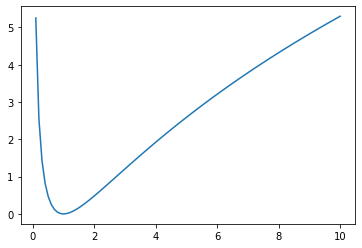

In [ ]:
import matplotlib.pyplot as plt
# Representa (empleando numpy y matplotlib la función f(x) = log(x)^2 (ver np.log) y obten el mínimo (np.min) y la posición del mismo (np.argmin)
# Para ello, crea un vector de 100 puntos equiespaciados en el rango [0,10] (ver np.linspace)

# Crear vector de puntos equiespaciados 
x_values = np.linspace(0, 10, 100) #(X)
# Crear f(x)
fx = np.log(x_values)**2 #(X)
# Mostrar por pantalla el mínimo (junto con su posición) y graficar la función
my_min = np.min(fx) #(X)
idx_min = x_values[np.argmin(fx)] #(X) 
print('Mínimo de la función y = ', my_min, ' en x= ', idx_min) 
plt.plot(x_values,fx)  


A continuación responda a las siguientes cuestiones acerca del ejemplo anterior:

- ¿Tienden a la misma solución ambas aproximaciones?¿Que significa esto? **Sol.** Sí ambas aproximaciones tienden al mismo valor mínimo. El SGD nos da una solución bastante certera del mínimo global de la función
- ¿Que efecto tendría sobre el valor del mínimo disminuir el valor de lr? **Sol.** Decrementar el lr puede significar que la precisión del mínimo aumente a costa de mayor CC
- Disminuye la tasa de aprendizaje a lr = 0.05, ¿Que observas?¿Que parámetro del código necesitas modificar para observar resultados coherentes? **Sol.** No le da tiempo a aprender lo suficiente para proporcionar una buena solución. Hay que aumentar el número de steps (épocas) a entrenar



---



Para poner en práctica todo lo aprendido, vamos a resolver uno de aquellos problemas de optimización típicos de bachillerato mediante TensorFlow.

**EJERCICIO 1.**  Xiaomi va a lanzar al mercado un nuevo smartphone y quiere diseñar el packaging del mismo. La idea es desarrollar un envase en forma de prisma de base cuadrada. El volumen del envase debe ser de 80 $cm^3$. El material para fabricar las caras laterales y la tapa del envase cuesta 1 céntimo de euro por $cm^2$. El material para fabricar la base debe ser más resistente y cuesta 1.5 céntimos de euro por $cm^2$.

1.   Calcula las dimensiones del envase para que su coste sea el menor posible.
2.   Calcula cuál es el coste mínimo, expresado en euros, que tendrá el envase.

Si recordaís con los datos del encunciado debemos plantear un sistema de ecuaciones. Una de las ecuaciones nos proporcionará una relación y la otra será la función objetivo a minimizar. VAMOS ALLÁ:

- El volumen de un prisma es $Vp = x * y * h$, como sabemos que la base es cuadrada: $Vp = x*x*h = 80$.
- Por otra parte tenemos que plantear otra ecuación que involucre la superficie del envase y la relacione con el coste: $C(x) = 1c€/cm^2 * (4x*h + x^2) + 1.5 c€/cm^2 * x^2$ = $4xh+x^2 + 1.5x^2$ = $4xh+2.5x^2$.

Bien, ahora que ya tenemos las dos ecuaciones, de la primera de ellas (la relación) despejamos $x$ y la sustituimos en la función de coste (función objetivo o función a minimizar), resultando:

$C(x) = \dfrac{320}{x} + 2.5x^2$

Esta es la función objetivo que debeís minimizar haciendo uso de la librería TensorFlow, tal y como hemos hecho antes con la función $y = log(x)^2$, para poder responder a las dos cuestiones planteadas en el enunciado.

In [ ]:
import tensorflow as tf
import numpy as np

# Hallemos el mínimo de la función C(x) = 320/x + 2.5x^2

# Inicialización de la variable x (Busca documentación acerca de la función random_uniform de TF)
x = tf.Variable(initial_value=tf.random.uniform([1], 0., 50.), name='x')

# Instanciar el optimizador SGD pasándole como parámetro un valor de 0.005 de learning rate
optimizer = tf.optimizers.SGD(learning_rate=0.005) #(X)

old_solution = 0
tolerance = 1e-4
for step in range(500):
    with tf.GradientTape() as tape:
        tape.watch(x)
        # Función de coste a minimizar (emplea tf.add, tf.divide, tf.multiply y tf.square)
        c = tf.add(tf.divide(320,x), tf.multiply(2.5, tf.square(x)), name='c') #(X)
        # Minimizamos la función objetivo
        grads = tape.gradient(c, x) #(X)
        # Actualizamos el valor de x
        optimizer.apply_gradients(grads_and_vars=[(grads, x)]) #(X)
        # Pedimos nueva solución de la variable x
        solution = x.numpy()
        # Comprobamos si se ha alcanzado la solución óptima
        if np.abs(solution - old_solution) < tolerance:
          print("\n El envase óptimo tendrá dimensiones x = {} cm, h = {} cm dando lugar a un coste de C = {} €".format(solution, 80/(solution*solution), c/100))
          break
        # Si no es así actualizo la solución vieja y muestro por pantalla 1 de cada 10 iteraciones
        old_solution = solution
        if step % 10 == 0:
          print('[INFO]: Step ', step, "---> x = " + str(old_solution), "- C = " + str(c))

[INFO]: Step  0 ---> x = [28.852762] - C = tf.Tensor([2199.8381], shape=(1,), dtype=float32)
[INFO]: Step  10 ---> x = [22.42129] - C = tf.Tensor([1335.6227], shape=(1,), dtype=float32)
[INFO]: Step  20 ---> x = [17.442766] - C = tf.Tensor([817.56506], shape=(1,), dtype=float32)
[INFO]: Step  30 ---> x = [13.601442] - C = tf.Tensor([508.8839], shape=(1,), dtype=float32)
[INFO]: Step  40 ---> x = [10.657626] - C = tf.Tensor([327.27103], shape=(1,), dtype=float32)
[INFO]: Step  50 ---> x = [8.432727] - C = tf.Tensor([223.15181], shape=(1,), dtype=float32)
[INFO]: Step  60 ---> x = [6.796144] - C = tf.Tensor([166.41464], shape=(1,), dtype=float32)
[INFO]: Step  70 ---> x = [5.649359] - C = tf.Tensor([138.20338], shape=(1,), dtype=float32)
[INFO]: Step  80 ---> x = [4.9040527] - C = tf.Tensor([126.05766], shape=(1,), dtype=float32)
[INFO]: Step  90 ---> x = [4.4634805] - C = tf.Tensor([121.71457], shape=(1,), dtype=float32)
[INFO]: Step  100 ---> x = [4.226148] - C = tf.Tensor([120.427246]

A continuación responda a las siguientes cuestiones acerca del ejemplo anterior:

- ¿Qué valor de tasa de aprendizaje y número de pasos has utilizado para el entrenamiento? Si has empleado los valores del ejercicio anterior observarás un comportamiento un tanto extraño en el proceso de aprendizaje. ¿Que significa esto? **Sol.** La tasa de aprendizaje del ejercicio anterior es muy alta para alcanzar el mínimo global en este problema.

- Prueba a fijar una tasa de aprendizaje 100 veces más pequeña para dar pasos mucho más cortos en la búsqueda de la solución óptima, por consiguiente establece un número de pasos mucho mayor, por ejemplo 500. ¿Que ocurre ahora? Justifica la respuesta. **Sol.** Ahora el proceso de aprendizaje es correcto y se obtienen resultados con mucho sentido. Con esto se ejemplifica perfectamente la importancia del learning rate y el número de épocas. Su influencia se estudiará detenidamente en la siguiente práctica.



---

Después de familiarizarnos con la librería TensorFlow es el momento de implementar la segunda red neuronal del curso. El objetivo de dicha red va a ser el de **identificar digitos del 0 al 9 escritos de forma manual**. El set de datos **MNIST** es un conjunto de  70000 imágenes de $28 \times 28$ pixels que contienen números manuscritos junto con la etiqueta solución del número codificado (i.e. nuestro ground truth). 

![mnist](https://drive.google.com/uc?id=1uvFNAFTVb58xPoSt_3F_9DLs47ZIyPFm)

Cabe destacar que, por convención, MNIST dispone de una división específica en conjuntos de entrenamiento, validación y test. Este dataset es el "Hola Mundo" del aprendizaje profundo y es de gran utilidad para validar nuevos métodos propuestos ya que hace de *benchmark* permitiendo establecer comparativas justas. Debido a su gran popularidad las principales librerias destinadas al aprendizaje profundo permiten cargarlo directamente en nuestro código. Así que sin más dilación vamos a cargar los datos y a visualizarlos:

El conjunto de entrenamiento tiene dimensiones:  (51000, 28, 28)
El conjunto de validación tiene dimensiones:  (9000, 28, 28)
El conjunto de test tiene dimensiones:  (10000, 28, 28)


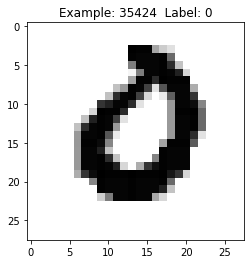

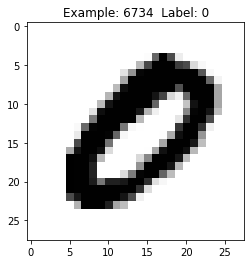

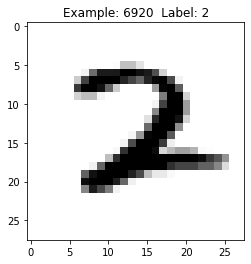

In [ ]:
# Imports necesarios
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Importamos el dataset MNIST y cargamos los datos
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)

# Comprobar el tamaño del dataset
print("El conjunto de entrenamiento tiene dimensiones: ", x_train.shape)
print("El conjunto de validación tiene dimensiones: ",x_val.shape)
print("El conjunto de test tiene dimensiones: ",x_test.shape)

# Método para visualizar los datos de entrenamiento
def display_digit(num):
  # Seleccionar la imagen num de imagenes de train
  image = x_train[num,:,:] #(X)
  # Seleccionar el target num de y_train 
  label = y_train[num] #(X)
  # Mostrar
  plt.title('Example: %d  Label: %d' % (num, label))
  plt.imshow(image, cmap=plt.get_cmap('gray_r'))
  plt.show()

# Mostramos algunos ejemplos
display_digit(np.random.randint(0, x_train.shape[0]))
display_digit(np.random.randint(0, x_train.shape[0]))
display_digit(np.random.randint(0, x_train.shape[0]))

# Ejecuta el código varias veces y comprueba la variabilidad existente en los datos

**EJERCICIO 2.** Una vez visualizadas ciertas muestras de nuestro conjunto de datos,  vamos a entrenar un **perceptrón simple** (como el de la primera sesión). Recordad que en el perceptrón simple las entradas se ponderan por ciertos pesos y se suman en cada una de las neuronas de salida. Posteriormente emplearemos la función **Softmax** que hemos explicado en la sesión teórica, calculando las predicciones como $\hat{Y}=softmax(X∗W+B)$ y minimizando la función de entropía cruzada o **cross-entropy** siguiendo la formula: 

>>>>>>>>$Coste = - \displaystyle\sum_j y_j log(p_j)$

donde $y_j$ es el *ground truth* para la clase $j$ y $p_j$ el valor de probabilidad asignado a dicha clase a la salida.

[INFO]: Época 0 ---> Acc_train = 0.7812139987945557 - Loss_train = 1.321060724964009 - Acc_val = 0.8304444551467896 - Loss_val = 0.8864030942749933
[INFO]: Época 1 ---> Acc_train = 0.8478168845176697 - Loss_train = 0.753756932452287 - Acc_val = 0.8557778000831604 - Loss_val = 0.6677553911267565
[INFO]: Época 2 ---> Acc_train = 0.8632341027259827 - Loss_train = 0.6145510505918075 - Acc_val = 0.8651111125946045 - Loss_val = 0.5780440256739517
[INFO]: Época 3 ---> Acc_train = 0.8701664805412292 - Loss_train = 0.5476960881097321 - Acc_val = 0.8735555410385132 - Loss_val = 0.5274405392130587
[INFO]: Época 4 ---> Acc_train = 0.8766160011291504 - Loss_train = 0.5067892374607672 - Acc_val = 0.8797777891159058 - Loss_val = 0.4944451157726773
[INFO]: Época 5 ---> Acc_train = 0.8809179663658142 - Loss_train = 0.47871757458427655 - Acc_val = 0.8837777972221375 - Loss_val = 0.470773035350938
[INFO]: Época 6 ---> Acc_train = 0.8839073181152344 - Loss_train = 0.45822803579021953 - Acc_val = 0.8875555

Text(0, 0.5, 'Loss')

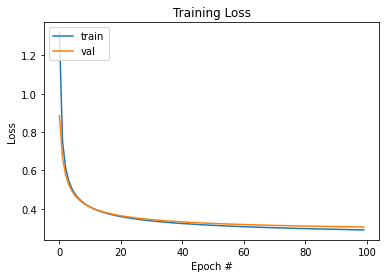

In [ ]:
# Hiper-parámetros de nuestra red
lr = 0.01
n_epochs = 100
batch_size = 128

#Normalizamos los datos
x_train = x_train / 255.
x_test = x_test / 255.
x_val= x_val / 255.

#Convertimos las imágenes a vectores, dado que aún no hemos visto cómo podemos implementar un modelo que trabaje con imágenes
x_train = tf.reshape(x_train, shape=(51000, -1)) # Nuestros datos ya están en formato [N_instancias, variables] (60000 instancias, 784 (28+28) pixels).
x_val = tf.reshape(x_val, shape=(9000, -1)) # Nuestros datos ya están en formato [N_instancias, variables] (9000 instancias, 784 (28+28) pixels).
x_test = tf.reshape(x_test, shape=(10000, -1)) # Nuestros datos ya están en formato [N_instancias, variables] (10000 instancias, 784 (28+28) pixels).

# Convertimos las etiquetas a one-hot y a float 64 ya que todos los datos deben estar en el mismo formato
y_train = tf.one_hot(y_train, depth=10) #(X)
y_val = tf.one_hot(y_val, depth=10) #(X)
y_test = tf.one_hot(y_test, depth=10) #(X)

y_train = tf.cast(y_train, 'float64') #(X)
y_val= tf.cast(y_val, 'float64') #(X)
y_test = tf.cast(y_test, 'float64') #(X)

#Nos creamos ahora el iterador para que recorra nuestro dataset. Podéis leer más sobre tf.data aquí: https://www.tensorflow.org/guide/data
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(10000).batch(batch_size)


#Calculamos las iteraciones por época
total_batch = x_train.shape[0] // batch_size

#Creamos e inicializamos con ceros las variables W y b
W = tf.zeros([784, 10], tf.double) #(X)
b = tf.zeros([10], tf.double) #(X)

# para almacenar el histórico de costes
acc_epoch_tr = []
acc_epoch_val = []
loss_epoch_tr = []
loss_epoch_val = []

# 6. Entrenamiento de nuestra red
for epoch in range(n_epochs):
    avg_loss = 0.
    avg_acc = 0.
    
    for batch_xs, batch_ys in train_ds:
        # Empezamos con la optimización
        # haremos uso de tf.GradientTape, que lleva un control de las variables
        # para poder calcular sus gradientes
        with tf.GradientTape() as tape:
            # le indicamos que "vigile" las variables a optimizar
            tape.watch(W) #(X)
            tape.watch(b) #(X)
            
            # ejecutamos el modelo
            pred = tf.nn.softmax(tf.matmul(batch_xs, W) + b) #(X)
            # calculamos el accuracy (precisión)
            correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(batch_ys, 1))
            acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            # Ahora, definimos nuestra función de pérdidas: esta vez, la cros-entropía
            cost = tf.reduce_mean(-tf.reduce_sum(batch_ys*tf.math.log(pred), axis=1)) #(X)
            # Calculamos los gradientes (gradient descent)
            grad_W, grad_b = tape.gradient(cost, [W, b]) #(X)

            # Definimos las operaciones para actualizar los pesos con los gradientes calculados
            # y el learning rate
            W = W - lr * grad_W #(X)
            b = b - lr * grad_b #(X)

        # Calculamos las perdidas y el accuracy teniendo en cuenta los batches que hay
        avg_loss += cost / total_batch
        avg_acc += acc / total_batch
        
    # Validamos el modelo en cada época
    pred = tf.nn.softmax(tf.matmul(x_val, W) + b) #(X)
    # Calculamos el accuracy (precisión)
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y_val, 1))
    acc_val = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # Ahora, definimos nuestra función de pérdidas: esta vez, la cros-entropía
    loss_val = tf.reduce_mean(-tf.reduce_sum(y_val*tf.math.log(pred), axis=1))  #(X)
    # guardamos nuestro coste en el histórico
    loss_epoch_tr.append(avg_loss) #(X)
    acc_epoch_tr.append(avg_acc) #(X)
    loss_epoch_val.append(loss_val) #(X)
    acc_epoch_val.append(acc_val) #(X)

    # imprimimos las iteraciones
    print("[INFO]: Época {} ---> Acc_train = {} - Loss_train = {} - Acc_val = {} - Loss_val = {}".format(epoch, avg_acc, avg_loss, acc_val, loss_val))


print("Entrenamiento finalizado!!")


# Comprobamos lo que ha aprendido nuestra red testeando el modelo
pred = tf.nn.softmax(tf.matmul(x_test, W) + b) #(X)
 
# calculamos el accuracy (precisión)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y_test, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy en test:", accuracy.numpy())

# Gráficar losses por época
plt.plot(np.arange(0, n_epochs), loss_epoch_tr)
plt.plot(np.arange(0, n_epochs), loss_epoch_val)
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
  #¿Que se puede observar de las gráficas?¿Según hemos visto en la teoría, se aprecia overfitting?